In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import arviz as az

import numpyro
import numpyro.distributions as dist
import numpyro.infer.initialization as init

from numpyro.infer.reparam import ProjectedNormalReparam
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp

from jax import random, vmap

_NUM_CHAINS = 10
numpyro.set_host_device_count(_NUM_CHAINS)

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

frac_age  delta_nu_fit      nu_max  nu_0_1     nu_0_2     nu_0_3  \
0  0.000016     11.884045  150.680452     0.0  34.481794  49.329712   
1  0.000017     12.140476  154.893200     0.0  35.203007  50.376320   
2  0.000017     12.343045  158.238356     0.0  35.772049  51.202159   
3  0.000018     12.503403  160.898485     0.0  36.222266  51.855582   
4  0.000018     12.633487  163.061612     0.0  36.587368  52.385499   

      nu_0_4     nu_0_5     nu_0_6      nu_0_7  ...     nu_0_32     nu_0_33  \
0  63.195077  75.913367  87.630758   99.483102  ...  392.064627  403.710370   
1  64.548471  77.583389  89.569246  101.679667  ...  400.620086  412.538305   
2  65.616199  78.900744  91.100159  103.413323  ...  407.368711  419.505074   
3  66.460893  79.942765  92.312228  104.785371  ...  412.708426  425.019262   
4  67.145867  80.787635  93.295718  105.898357  ...  417.037759  429.491253   

      nu_0_34     nu_0_35     nu_0_36     nu_0_37     nu_0_38     nu_0_39  \
0  415.297909  426.924218  438.655667  450.550178  462.546781  474.658899   
1  424.386957  436.252351  448.212638  460.326691  472.558635  484.919720   
2  431.563921  443.619056  455.762984  468.048949  480.469626  493.018551   
3  437.245702  449.452226  461.742276  474.164224  486.734715  499.427290   
4  441.854064  454.184875  466.594022  479.127384  491.819429  504.626946   

      nu_0_40  surface_he4  
0  486.825847     0.239966  
1  497.325734     0.239967  
2  505.616340     0.239968  
3  512.179364     0.239969  
4  517.505773     0.239969  

[5 rows x 44 columns]

In [3]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
n = np.arange(10, 30)

In [6]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


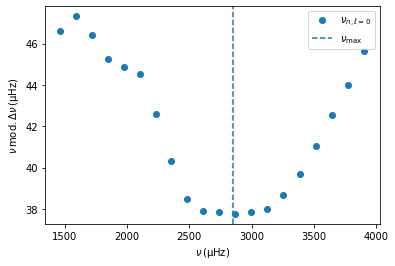

In [7]:
nu_mod = nu % delta_nu_fit

fig, ax = plt.subplots()

ax.plot(nu, nu_mod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [8]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def glitch(nu, tau, phi, lib=jnp):
    return lib.sin(4 * np.pi * tau * nu + phi)
    
def he_amplitude(nu, b0, b1, lib=jnp):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=jnp):
    return he_amplitude(nu, b0, b1, lib=lib) * glitch(nu, tau_he, phi_he, lib=lib)

def cz_amplitude(nu, c0):
    return c0 / nu**2

def cz_glitch(nu, c0, tau_cz, phi_cz, lib=jnp):
    return cz_amplitude(nu, c0) * glitch(nu, tau_cz, phi_cz, lib=lib)

In [9]:
_epsilon = [1.3, 0.2]
_alpha = [np.log(0.001), 1.0]
_delta_nu = [delta_nu_fit, 1.0]
_nu_max = [nu_max_sca, 0.05*nu_max_sca]

def model_asy(n, nu, nu_err=None):
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    if nu_err is None:
        nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.5))
    
    nu_model = asy_background(n, epsilon, alpha, delta_nu, nu_max)
    
    nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

Numpyro makes use of random keys. We can create a random key and then split it every time we wish to use one.

In [10]:
rng_gene = random.PRNGKey(53)
rng_gene, rng_key = random.split(rng_gene)

num_warmup, num_samples = 2000, 2000

kernel = NUTS(model_asy, target_accept_prob=0.8, init_strategy=init.init_to_median)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=_NUM_CHAINS)
mcmc.run(rng_key, n, nu)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.00      0.00      0.00      0.00   8843.46      1.00
  delta_nu    128.70      0.21    128.70    128.35    129.03   4719.45      1.00
   epsilon      1.30      0.04      1.30      1.24      1.36   4648.34      1.00
    nu_err      1.23      0.17      1.21      0.96      1.49   8035.11      1.00
    nu_max   2855.16    138.81   2856.19   2632.20   3087.96   5051.75      1.00

Number of divergences: 0


In [12]:
trace_asy = az.from_numpyro(mcmc)

In [13]:
az.summary(trace_asy)

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha        0.001    0.000     0.001     0.002      0.000    0.000    8999.0   
delta_nu   128.696    0.207   128.312   129.090      0.003    0.002    4739.0   
epsilon      1.300    0.036     1.230     1.365      0.001    0.000    4677.0   
nu_err       1.228    0.166     0.927     1.539      0.002    0.001    8264.0   
nu_max    2855.163  138.814  2602.114  3124.678      1.951    1.380    5064.0   

          ess_tail  r_hat  
alpha       8071.0    1.0  
delta_nu    6120.0    1.0  
epsilon     6022.0    1.0  
nu_err      9191.0    1.0  
nu_max      6860.0    1.0

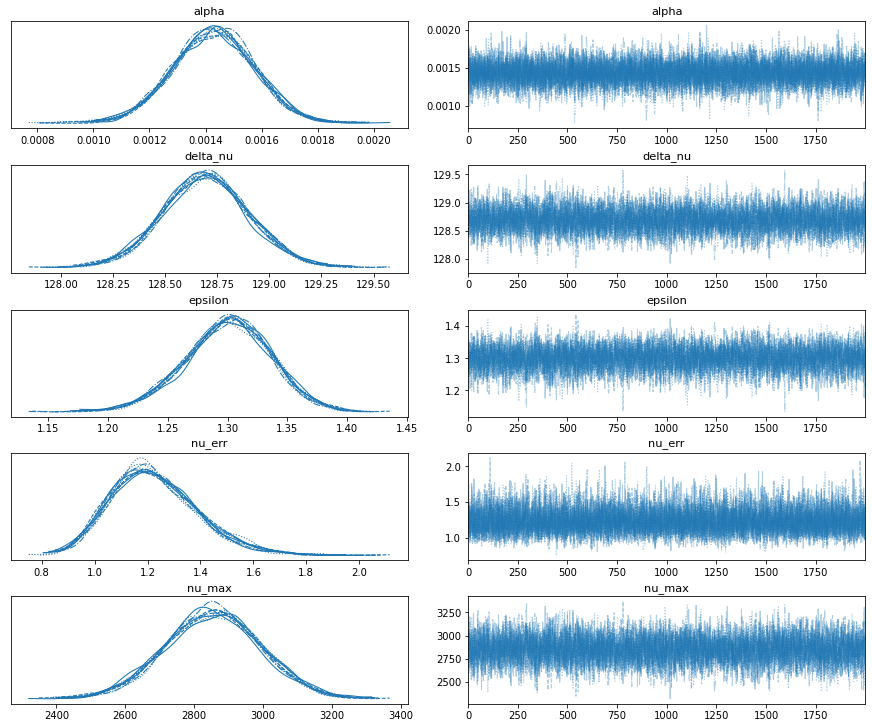

In [14]:
az.plot_trace(trace_asy, compact=True);

In [15]:
nu_model = asy_background(n[:, np.newaxis, np.newaxis], 
                          *trace_asy.posterior[['epsilon', 'alpha', 'delta_nu', 'nu_max']].to_array().values)

In [16]:
nu_model_16 = np.quantile(nu_model, .16, axis=(1, 2))
nu_model_med = np.median(nu_model, axis=(1, 2))
nu_model_84 = np.quantile(nu_model, .84, axis=(1, 2))

nu_model_err = [nu_model_med - nu_model_16, nu_model_84 - nu_model_med]

In [17]:
nu_err = trace_asy.posterior['nu_err'].values

In [18]:
nu_err_16 = np.quantile(nu_err, .16)
nu_err_med = np.median(nu_err)
nu_err_84 = np.quantile(nu_err, .84)

nu_err_err = [nu_err_med - nu_err_16, nu_err_84 - nu_err_med]

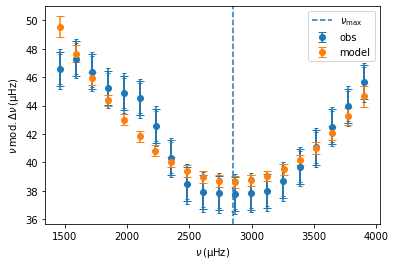

In [19]:
fig, ax = plt.subplots()

# Observed
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_med, fmt='o', capsize=4, label=r'obs')

# Upper and lower limits on the error
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_16, fmt='none', capsize=2)
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_84, fmt='none', capsize=2)

# Model
ax.errorbar(nu_model_med, nu_model_med % delta_nu_fit, yerr=nu_model_err, fmt='o', capsize=4, label='model')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [225]:
m_tau = 1.05

def circular_transform(x):
    return jnp.arctan2(jnp.sin(x), jnp.cos(x))

def model_he_glitch(n, nu, nu_err=None):
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    b0 = numpyro.sample('b0', dist.LogNormal(np.log(1/_nu_max[0]), 1.0))
    b1 = numpyro.sample('b1', dist.LogNormal(np.log(1/_nu_max[0]**2), 1.0))
        
    tau_he = numpyro.sample('tau_he', dist.LogNormal(-m_tau*np.log(_nu_max[0]), 1.0))
    
    phi_he = numpyro.sample('phi_he', dist.Normal(0.0, 10.0))
    phi_he = circular_transform(phi_he)

    if nu_err is None:
        nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.5))
    
    nu_asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)

    nu_model = nu_asy + he_glitch(nu_asy, b0, b1, tau_he, phi_he)
    
    nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

In [205]:
rng_gene, rng_key = random.split(rng_gene)

In [206]:
model_args = (n, nu)
model_kwargs = {'nu_err': None}

kernel = NUTS(model_he_glitch, target_accept_prob=0.95,
              init_strategy=init.init_to_median)

def postprocess_fn(x):
    x = kernel.postprocess_fn(model_args, model_kwargs)(x)
    x['phi_he'] = circular_transform(x['phi_he'])
    x['nu_asy'] = asy_background(model_args[0], x['epsilon'], x['alpha'], x['delta_nu'], x['nu_max'])
    x['nu_model'] = x['nu_asy'] + he_glitch(x['nu_asy'], x['b0'], x['b1'], x['tau_he'], x['phi_he'])
    return x

In [207]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=_NUM_CHAINS, 
            postprocess_fn=postprocess_fn)
mcmc.run(rng_key, *model_args, **model_kwargs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [208]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.00      0.00      0.00      0.00   4318.31      1.00
        b0      0.00      0.00      0.00      0.00      0.01   5813.98      1.00
        b1      0.00      0.00      0.00      0.00      0.00   4555.24      1.00
  delta_nu    128.78      0.18    128.77    128.50    129.08   5062.39      1.00
   epsilon      1.30      0.03      1.30      1.24      1.35   5032.16      1.00
    nu_err      0.53      0.11      0.52      0.37      0.70   7116.19      1.00
    nu_max   2847.45    141.71   2848.59   2615.58   3079.48   8647.98      1.00
    phi_he     -0.33      2.24     -1.36     -3.14      2.79   7092.32      1.00
    tau_he      0.00      0.00      0.00      0.00      0.00   4580.51      1.00

Number of divergences: 0


In [209]:
trace_he_glitch = az.from_numpyro(mcmc)

In [212]:
az.summary(trace_he_glitch).head()

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha       0.001  0.000    0.000    0.002      0.000    0.000    4443.0   
b0          0.003  0.002    0.001    0.007      0.000    0.000    5724.0   
b1          0.000  0.000    0.000    0.000      0.000    0.000    4544.0   
delta_nu  128.784  0.180  128.467  129.139      0.003    0.002    5171.0   
epsilon     1.296  0.032    1.234    1.352      0.000    0.000    5163.0   

          ess_tail  r_hat  
alpha       7448.0    1.0  
b0          8770.0    1.0  
b1          7185.0    1.0  
delta_nu    6717.0    1.0  
epsilon     6743.0    1.0

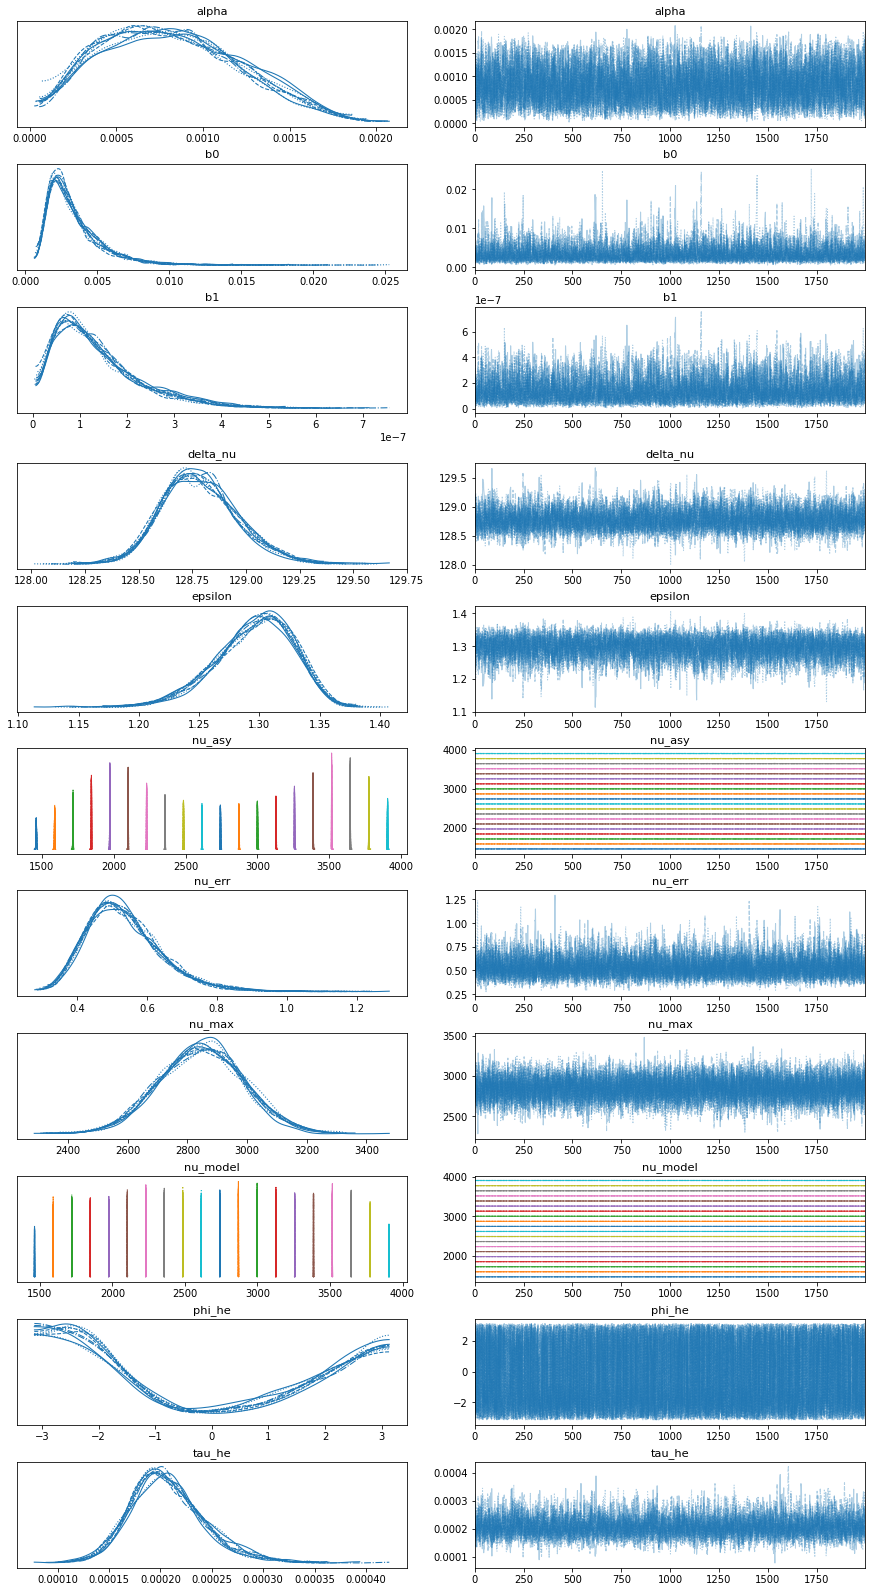

In [211]:
az.plot_trace(trace_he_glitch, compact=True);

## Model He + BCZ glitch

In [252]:
from numpyro.infer.util import initialize_model


0.0007063559469229126

In [254]:
m_tau = 1.05
s_tau = 2.5  # Scale factor tau_cz ~ s_tau * tau_he 

def circular_transform(x):
    return jnp.arctan2(jnp.sin(x), jnp.cos(x))

def model_hecz_glitch(n, nu, nu_err=None):
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    b0 = numpyro.sample('b0', dist.LogNormal(np.log(1/_nu_max[0]), 0.8))
    b1 = numpyro.sample('b1', dist.LogNormal(np.log(1/_nu_max[0]**2), 0.8))
    
    log_tau = - m_tau * np.log(_nu_max[0])  # Approx form of log(tau_he)
    tau_he = numpyro.sample('tau_he', dist.LogNormal(log_tau, 0.8))
    
    phi_he = numpyro.sample('phi_he', dist.Normal(0.0, 10.0))
    phi_he = circular_transform(phi_he)

    c0 = numpyro.sample('c0', dist.LogNormal(np.log(_nu_max[0]**2), 0.8))
    tau_cz = numpyro.sample('tau_cz', dist.LogNormal(log_tau + np.log(s_tau), 0.8))
    
    phi_cz = numpyro.sample('phi_cz', dist.Normal(0.0, 10.0))
    phi_cz = circular_transform(phi_cz)
    
#     delta_tau_logp = pm.Lognormal.dist(np.log(0.001), 0.8).logp(tau_cz - tau_he)
#     delta_tau = pm.Potential('delta_tau', delta_tau_logp)
#     delta_tay_logp = dist.LogNormal(log_tau, 0.8).log_prob(tau_cz - tau_he)
#     delta_tau = numpyro.sample()
#     dist....

    if nu_err is None:
        nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.5))
    
    nu_asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)

    nu_model = nu_asy + he_glitch(nu_asy, b0, b1, tau_he, phi_he) + cz_glitch(nu_asy, c0, tau_cz, phi_cz)
    
#     nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

In [255]:
model_args = (n, nu)
model_kwargs = {'nu_err': None}

# model_info = initialize_model(rng_key, model_hecz_glitch, model_args=model_args, model_kwargs=model_kwargs,
#                              init_strategy=init.init_to_median)

In [266]:
# kernel = NUTS(potential_fn=model_info.potential_fn, target_accept_prob=0.95)

In [245]:
rng_gene, rng_key = random.split(rng_gene)

In [258]:
kernel = NUTS(model_hecz_glitch, target_accept_prob=0.95,
              init_strategy=init.init_to_median)

def postprocess_fn(x):
    x = kernel.postprocess_fn(model_args, model_kwargs)(x)
    x['phi_he'] = circular_transform(x['phi_he'])
    x['phi_cz'] = circular_transform(x['phi_cz'])
    x['nu_asy'] = asy_background(model_args[0], x['epsilon'], x['alpha'], x['delta_nu'], x['nu_max'])
    x['nu_model'] = x['nu_asy'] + he_glitch(x['nu_asy'], x['b0'], x['b1'], x['tau_he'], x['phi_he']) + \
        cz_glitch(x['nu_asy'], x['c0'], x['tau_cz'], x['phi_cz'])
    return x

In [269]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=_NUM_CHAINS, 
            postprocess_fn=postprocess_fn)
mcmc.run(rng_key, *model_args, **model_kwargs)

IndexError: tuple index out of range

In [248]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.00      0.00      0.00      0.00  13128.35      1.00
        b0      0.00      0.00      0.00      0.00      0.00  14314.40      1.00
        b1      0.00      0.00      0.00      0.00      0.00  15614.38      1.00
        c0 11134774.00 10588868.00 8115273.00 931568.56 22888344.00  14547.37      1.00
  delta_nu    128.71      1.01    128.70    127.05    130.38  18188.50      1.00
   epsilon      1.30      0.20      1.30      0.97      1.63  18789.34      1.00
    nu_err      0.40      0.30      0.33      0.00      0.82  20024.78      1.00
    nu_max   2854.13    142.66   2853.59   2619.94   3087.18  19797.76      1.00
    phi_cz     -0.01      1.81     -0.01     -2.59      3.05  20576.94      1.00
    phi_he     -0.02      1.80     -0.04     -3.03      2.59  20320.53      1.00
    tau_cz      0.00      0.00      0.00      0.00      0.00   8572.38      1.00
    tau_he      0.00

In [249]:
trace_hecz_glitch = az.from_numpyro(mcmc)
az.summary(trace_hecz_glitch).head()

mean            sd      hdi_3%       hdi_97%  mcse_mean  \
alpha     2.000000e-03  2.000000e-03       0.000  5.000000e-03      0.000   
b0        0.000000e+00  0.000000e+00       0.000  1.000000e-03      0.000   
b1        0.000000e+00  0.000000e+00       0.000  0.000000e+00      0.000   
c0        1.113477e+07  1.058887e+07  681225.875  2.797495e+07  87479.841   
delta_nu  1.287060e+02  1.009000e+00     126.804  1.305730e+02      0.007   

            mcse_sd  ess_bulk  ess_tail  r_hat  
alpha         0.000   18973.0   13366.0    1.0  
b0            0.000   18364.0   13841.0    1.0  
b1            0.000   19847.0   14548.0    1.0  
c0        64466.432   19028.0   13173.0    1.0  
delta_nu      0.005   18250.0   14010.0    1.0

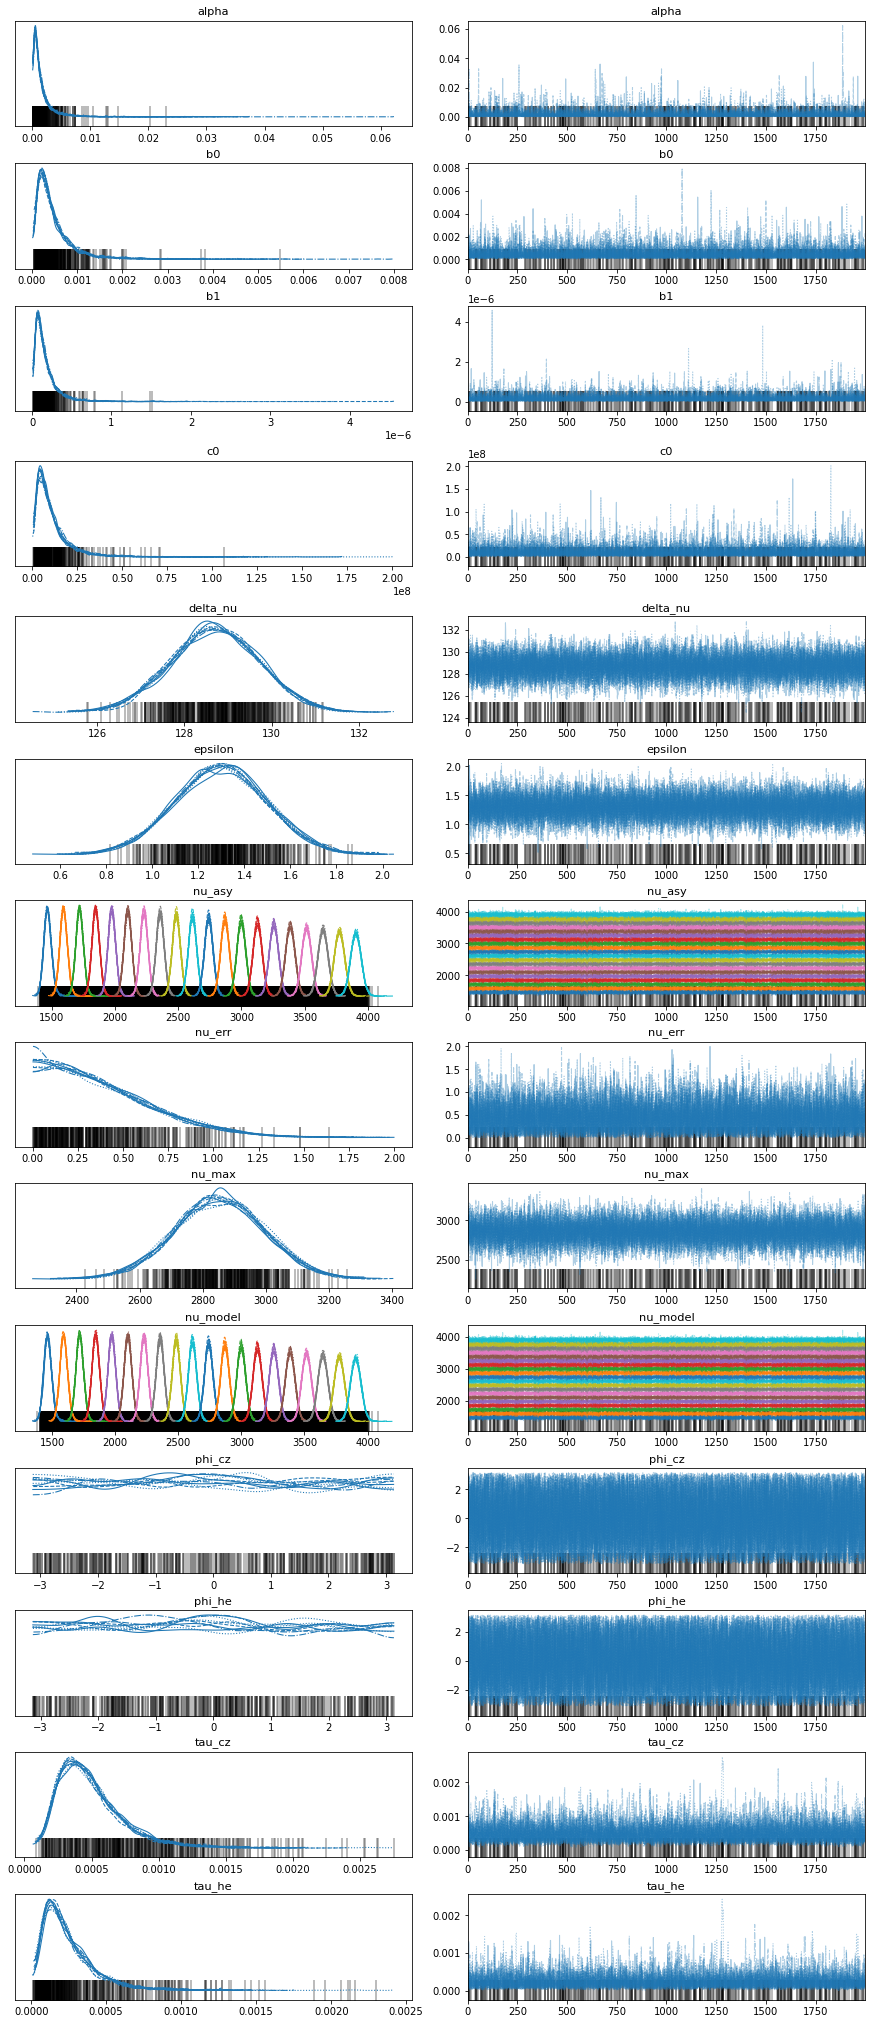

In [250]:
az.plot_trace(trace_hecz_glitch, compact=True);

In [28]:
with pm.Model() as model_glitch_hecz:
    
    # Asymptotic background
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    # He glitch
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0)
    tau_he = pm.Lognormal('tau_he', np.log(0.0005), 0.8)
    phi_he = pm.VonMises('phi_he', 0.0, 0.1)
    
    
    # BCZ glitch
    c0 = pm.Lognormal('c0', np.log(numax**2), 1.0)
    tau_cz = pm.Lognormal('tau_cz', tt.log(0.001), 0.8)
    phi_cz = pm.VonMises('phi_cz', 0.0, 0.1)
    
    delta_tau_logp = pm.Lognormal.dist(np.log(0.001), 0.8).logp(tau_cz - tau_he)
    delta_tau = pm.Potential('delta_tau', delta_tau_logp)
    
    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))

    amp_he = pm.Deterministic('amp_he', he_amplitude(nu_asy, b0, b1))
    amp_cz = pm.Deterministic('amp_cz', cz_amplitude(nu_asy, c0))
    
#     delta_amp_logp = pm.Lognormal.dist(np.log(0.1), 0.5).logp(amp_cz/amp_he)
#     delta_amp = pm.Potential('delta_amp', delta_amp_logp)
    
#     dnu_he = pm.Deterministic('dnu_he', he_glitch(nu_asy, b0, b1, tau_he, phi_he))
#     dnu_cz = pm.Deterministic('dnu_cz', cz_glitch(nu_asy, c0, tau_cz, phi_cz))
    
    dnu_he = pm.Deterministic('dnu_he', amp_he * glitch(nu_asy, tau_he, phi_he))
    dnu_cz = pm.Deterministic('dnu_cz', amp_cz * glitch(nu_asy, tau_cz, phi_cz))

    nu_model = pm.Deterministic('nu_model', nu_asy + dnu_he + dnu_cz)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

AttributeError: 'TensorVariable' object has no attribute 'logp'

In [82]:
with model_glitch_hecz:
    trace_glitch_hecz = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:19.981393
Transformation time =  0 days 00:02:55.003689


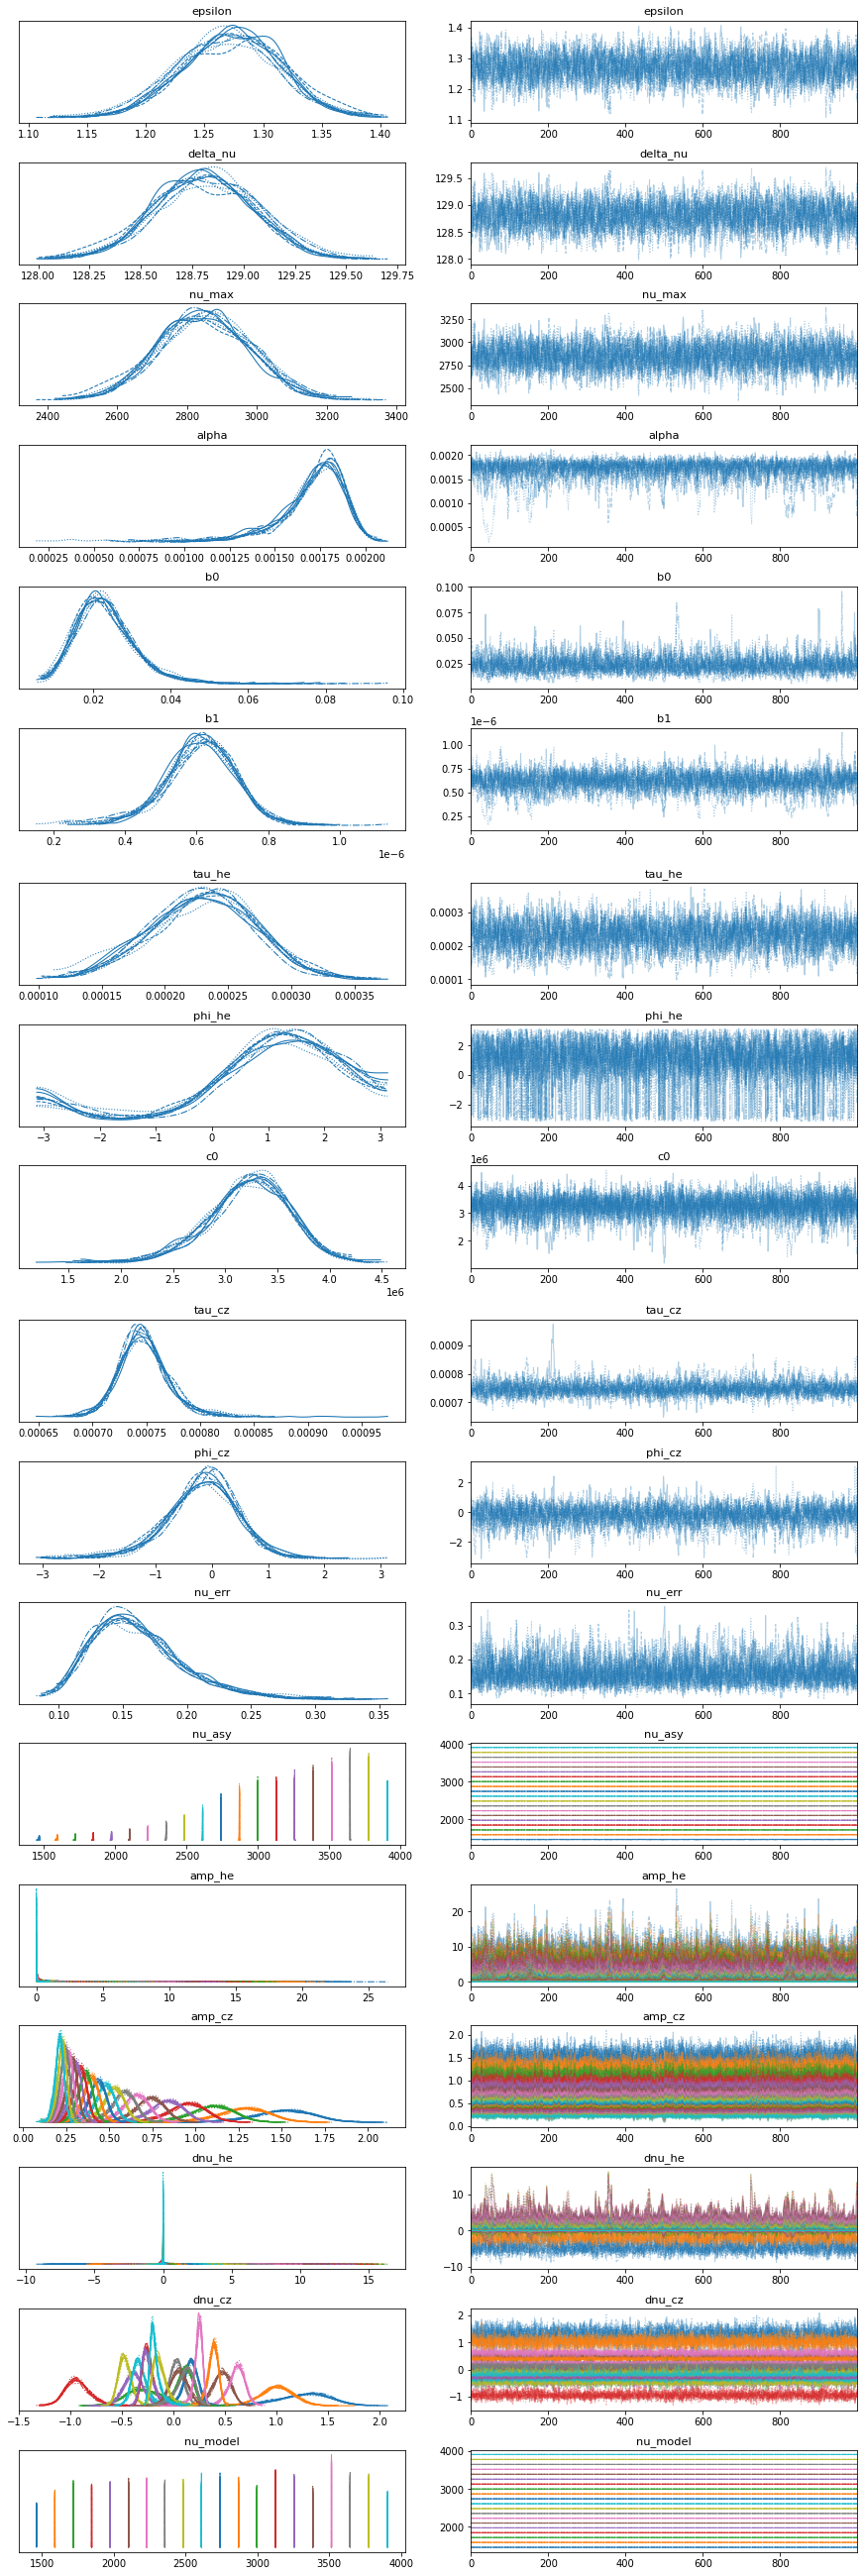

In [83]:
with model_glitch_hecz:
    ax = az.plot_trace(trace_glitch_hecz, compact=True)

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [94]:
dnu_he = trace_glitch_hecz.posterior['dnu_he'].values
dnu_cz = trace_glitch_hecz.posterior['dnu_cz'].values
nu_glitch_hecz = dnu_he + dnu_cz

In [95]:
nu_glitch_hecz = nu_glitch_hecz.reshape(
        (nu_glitch_hecz.shape[0]*nu_glitch_hecz.shape[1],
         nu_glitch_hecz.shape[2])
    )
nu_glitch_hecz.shape

(10000, 20)

In [96]:
nu_model_hecz = trace_glitch_hecz.posterior['nu_model'].values

In [97]:
nu_model_hecz = nu_model_hecz.reshape(
        (nu_model_hecz.shape[0]*nu_model_hecz.shape[1],
         nu_model_hecz.shape[2])
    )
nu_model_hecz.shape

(10000, 20)

In [114]:
nu_asy_hecz = trace_glitch_hecz.posterior['nu_asy'].values

In [115]:
nu_asy_hecz = nu_asy_hecz.reshape(
        (nu_asy_hecz.shape[0]*nu_asy_hecz.shape[1],
         nu_asy_hecz.shape[2])
    )
nu_asy_hecz.shape

(10000, 20)

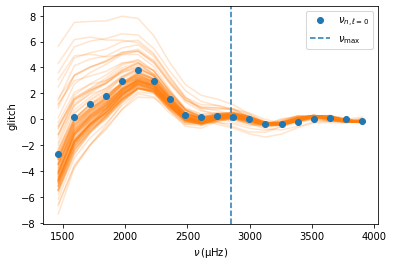

In [116]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model_hecz.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_glitch_hecz[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - nu_asy_hecz.mean(axis=0), 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [120]:
post = trace_glitch_hecz.posterior

In [135]:
he_args = post[['b0', 'b1', 'tau_he', 'phi_he']].to_dataframe()
cz_args = post[['c0', 'tau_cz', 'phi_cz']].to_dataframe()

In [138]:
he_args.to_numpy().shape

(10000, 4)

In [159]:
n_range = 500
nu_range = np.linspace(nu[0], nu[-1], n_range)

dnu_he = he_glitch(nu_range[:, np.newaxis], *he_args.to_numpy().T, lib=np)
dnu_cz = cz_glitch(nu_range[:, np.newaxis], *cz_args.to_numpy().T, lib=np)

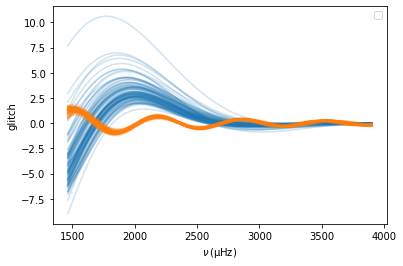

In [163]:
n_samples = 100
samples = np.random.choice(np.arange(dnu_he.shape[-1]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_range, dnu_he[:, samples], '-', color='C0', alpha=0.2)
ax.plot(nu_range, dnu_cz[:, samples], '-', color='C1', alpha=0.2)

ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

In [165]:
nu_asy_hecz.shape

(10000, 20)

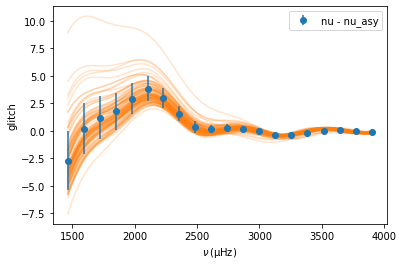

In [172]:
fig, ax = plt.subplots()

ax.plot(nu_range, dnu_he[:, samples] + dnu_cz[:, samples], '-', color='C1', alpha=0.2)
ax.errorbar(nu, nu - nu_asy_hecz.mean(axis=0), yerr=nu_asy_hecz.std(axis=0), fmt='o', zorder=10, label='nu - nu_asy')

ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [190]:
glitch = (dnu_he + dnu_cz)
glitch_upper = np.quantile(glitch, .84, axis=1)
glitch_median = np.median(glitch, axis=1)
glitch_lower = np.quantile(glitch, .16, axis=1)


In [211]:
nu_asy_med = np.median(nu_asy_hecz, axis=0)
nu_asy_err = [nu_asy_med - np.quantile(nu_asy_hecz, .16, axis=0), 
              np.quantile(nu_asy_hecz, .84, axis=0) - nu_asy_med]

In [222]:
nu_asy_err[::-1]  # Because we plot nu - nu_asy we flip the errors

[array([1.50807542, 1.30011661, 1.09774245, 0.91959133, 0.7604072 ,
        0.6145763 , 0.48654685, 0.36748345, 0.27405285, 0.2037971 ,
        0.15770026, 0.13995331, 0.14553639, 0.15061752, 0.15246011,
        0.14397077, 0.12071187, 0.09798338, 0.09082011, 0.1250745 ]),
 array([2.66971374, 2.3097068 , 1.98417111, 1.68066289, 1.39915686,
        1.1446304 , 0.9111904 , 0.7039612 , 0.524356  , 0.37585095,
        0.25879598, 0.17054608, 0.1263931 , 0.11147041, 0.10465445,
        0.09721008, 0.08611174, 0.07717655, 0.09228941, 0.14711508])]

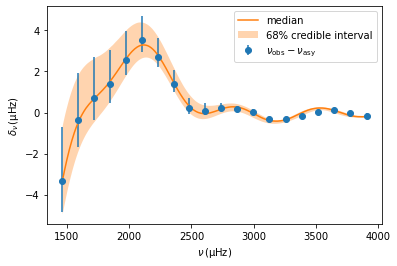

In [227]:
fig, ax = plt.subplots()

ax.errorbar(nu, nu - nu_asy_med, yerr=nu_asy_err[::-1], fmt='o', label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$')

ax.plot(nu_range, glitch_median, '-', color='C1', label='median')
ax.fill_between(nu_range, glitch_lower, glitch_upper, color='C1', alpha=0.33, linewidth=0, label='68% credible interval')

ax.set_ylabel(r'$\delta_\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

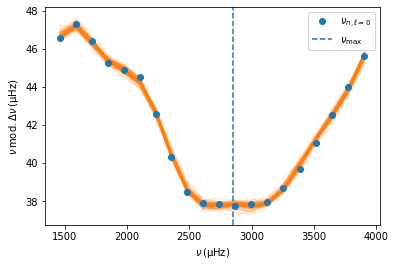

In [99]:
fig, ax = plt.subplots()

ax.plot(nu_model_hecz[samples].T, nu_model_hecz[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()